In [1]:
import nibabel as nib
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data

## Training data

In [23]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [24]:
scan_dimension = scan_100206.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [25]:
scan_100206_long = np.reshape(scan_100206, (x*y*z, b))

mask_100206_long = np.reshape(mask_100206, (x*y*z, 1))

In [26]:
# Error voxels
indices_beginning_0_all = np.where(scan_100206_long[:, 0] == 0)[0]

In [27]:
mask_100206_long_pro = np.copy(mask_100206_long)
mask_100206_long_pro[indices_beginning_0_all] = 0

In [7]:
scan_100206_long_no_background = process_data.remove_background(scan_100206_long, mask_100206_long_pro)

In [6]:
bvals_all = np.loadtxt(config.data_folder2 + '/100206/bvals') * 1e-3

In [14]:
S0_100206 = process_data.get_S0(scan_100206_long_no_background, bvals_all)

In [15]:
normalized_scan_100206 = scan_100206_long_no_background / S0_100206

In [16]:
len(np.where(S0_100206 < 100)[0])

609

In [8]:
big_b_indices = np.where(bvals_all != 0.005)[0]

In [9]:
bvals = bvals_all[big_b_indices]

In [19]:
normalized_scan_100206_no_b5 = normalized_scan_100206[:, big_b_indices]

In [20]:
normalized_scan_100206_no_b5.shape

(935442, 270)

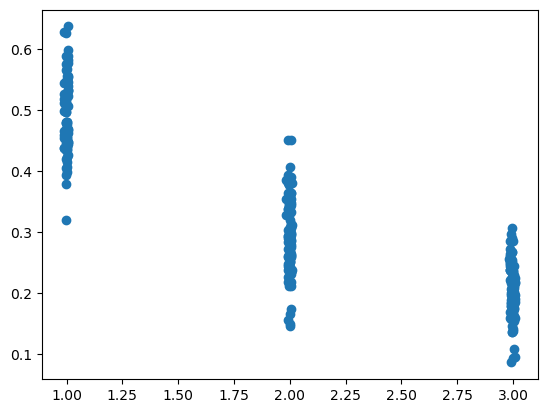

In [21]:
plt.plot(bvals, normalized_scan_100206_no_b5[1565,:], "o")

In [46]:
np.save("normalized_scan_100206_no_b5.npy",normalized_scan_100206_no_b5)

In [2]:
normalized_scan_100206_no_b5 = np.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/normalised_data/normalized_scan_100206_no_b5.npy")

## Neural Network

In [3]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [4]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [5]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [10]:
n_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')
n = n_all[:,big_b_indices].T
print(n.shape)

b_values = torch.FloatTensor(bvals)
gradient_directions = torch.FloatTensor(n)

net = BallStickNet(gradient_directions, b_values)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

(270, 3)


In [11]:
batch_size = 128
num_batches = len(normalized_scan_100206_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [ ]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 119.71it/s]


Loss: 445.04903111886233
Average Loss: 0.060898882200172734
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.69it/s]


Loss: 428.55537268333137
Average Loss: 0.05864195028507545
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.49it/s]


Loss: 426.73546150233597
Average Loss: 0.05839292029314942
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 139.67it/s]


Loss: 425.9081941321492
Average Loss: 0.058279720050923536
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:19<00:00, 92.47it/s]


Loss: 431.4240349624306
Average Loss: 0.05903448754275186
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.70it/s]


Loss: 430.7029609705787
Average Loss: 0.05893581841414597
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.51it/s]


Loss: 421.8613139218651
Average Loss: 0.05772595975942325
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 107.92it/s]


Loss: 423.0010139865335
Average Loss: 0.05788191214922462
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 1


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:15<00:00, 96.71it/s]


Loss: 428.9636738188565
Average Loss: 0.058697820719602695
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.95it/s]


Loss: 421.4031513161026
Average Loss: 0.057663266463615574
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|▉                                                         | 119/7308 [00:04<01:02, 115.50it/s]

X_batch: 
torch.Size([128, 270])
tensor([[0.4576, 0.1966, 0.1693,  ..., 0.4692, 0.3123, 0.2694],
        [0.5098, 0.2216, 0.1407,  ..., 0.5128, 0.2816, 0.1558],
        [0.4971, 0.3064, 0.2193,  ..., 0.5793, 0.3030, 0.1661],
        ...,
        [0.4365, 0.1795, 0.3774,  ..., 0.5650, 0.3907, 0.2231],
        [0.3642, 0.2104, 0.0938,  ..., 0.3602, 0.2171, 0.1323],
        [0.5834, 0.3586, 0.1481,  ..., 0.4482, 0.4265, 0.3234]])
X_pred: 
torch.Size([128, 270])
tensor([[0.4212, 0.2570, 0.1391,  ..., 0.3990, 0.2855, 0.2515],
        [0.5012, 0.2831, 0.1589,  ..., 0.4922, 0.2824, 0.1832],
        [0.5261, 0.2950, 0.1766,  ..., 0.5237, 0.2982, 0.1856],
        ...,
        [0.5140, 0.2301, 0.3167,  ..., 0.5298, 0.4211, 0.2191],
        [0.3835, 0.1924, 0.1074,  ..., 0.3747, 0.1905, 0.1279],
        [0.4746, 0.3034, 0.1629,  ..., 0.4583, 0.3243, 0.3051]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 158.90it/s]


Loss: 419.2649870107416
Average Loss: 0.057370687877769784
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.77it/s]


Loss: 417.66043570335023
Average Loss: 0.05715112694353451
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.19it/s]


Loss: 419.7819711724296
Average Loss: 0.05744143010022299
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.68it/s]


Loss: 421.82932415558025
Average Loss: 0.05772158239676796
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:11<00:00, 102.82it/s]


Loss: 418.34084401396103
Average Loss: 0.05724423152900397
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.73it/s]


Loss: 421.83929342683405
Average Loss: 0.05772294655539601
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 108.97it/s]


Loss: 423.30099412379786
Average Loss: 0.057922960334400364
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 5


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:13<00:00, 99.00it/s]


Loss: 422.9501036715228
Average Loss: 0.057874945767860266
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.81it/s]


Loss: 418.63673052587546
Average Loss: 0.057284719557454226
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 119.29it/s]


Loss: 416.4031164564658
Average Loss: 0.05697907997488585
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:12<00:00, 100.58it/s]


Loss: 416.7496337699704
Average Loss: 0.05702649613710596
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 106.75it/s]


Loss: 416.9781957312953
Average Loss: 0.05705777172021008
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 2


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:20<00:00, 90.51it/s]


Loss: 419.97856998071074
Average Loss: 0.05746833196233043
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 103.94it/s]


Loss: 420.6848619664088
Average Loss: 0.05756497837526119
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 109.44it/s]


Loss: 416.4109092503786
Average Loss: 0.056980146312312345
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.31it/s]


Loss: 416.2738017060328
Average Loss: 0.056961385017245875
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.78it/s]


Loss: 422.4472202183679
Average Loss: 0.05780613303480677
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.60it/s]


Loss: 445.05115480395034
Average Loss: 0.060899172797475414
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.70it/s]


Loss: 427.54626285936683
Average Loss: 0.0585038673863392
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.25it/s]


Loss: 422.0149220796302
Average Loss: 0.05774697893809937
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 4


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:19<00:00, 92.36it/s]


Loss: 424.2436076248996
Average Loss: 0.058051944119444386
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 109.00it/s]


Loss: 423.47810287959874
Average Loss: 0.05794719524898724
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.06it/s]


Loss: 423.67352785007097
Average Loss: 0.05797393648742077
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 106.01it/s]


Loss: 422.9425945584662
Average Loss: 0.057873918248284924
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 8


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:19<00:00, 92.39it/s]


Loss: 422.6953799210023
Average Loss: 0.05784009030117711
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 9


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.40it/s]

Loss: 450.5423523588106
Average Loss: 0.06165056819359751
Done, best loss: 416.2738017060328
Done


<All keys matched successfully>

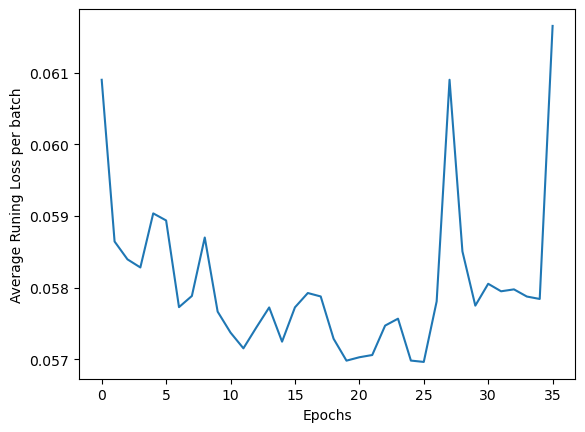

In [13]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [65]:
torch.save(final_model, 'model_100206_norm_01_Feb_3.pt')

In [14]:
net.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=270, out_features=5, bias=True)
  )
)

In [15]:
X_pred_train, mu_cart_pred_train, lambda_par_pred_train, lambda_iso_pred_train,  volume_0_pred_train, volume_1_pred_train = net(torch.from_numpy(normalized_scan_100206_no_b5.astype(np.float32)))

In [16]:
lambda_iso_pred_train.shape

torch.Size([935442, 1])

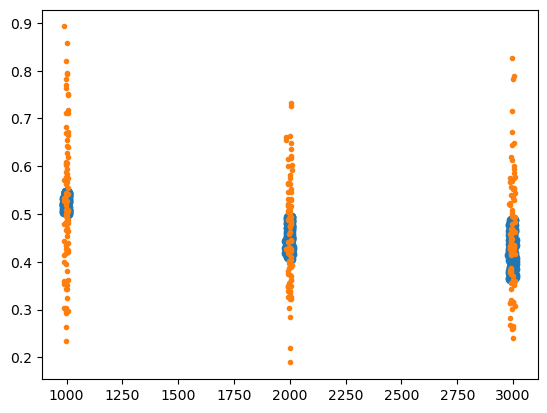

In [17]:
plt.plot(bvals*1e03, X_pred_train[0,:].detach().numpy(),  "o")
plt.plot(bvals*1e03,normalized_scan_100206_no_b5[0,:], ".")

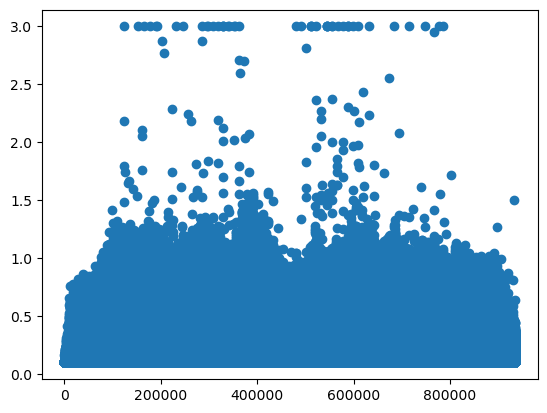

In [18]:
plt.plot(lambda_par_pred_train.detach().numpy(), 'o')

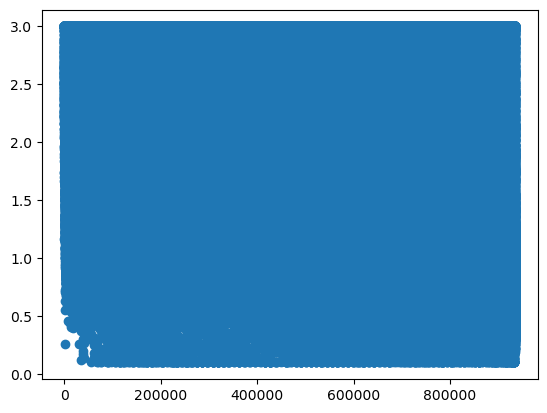

In [19]:
plt.plot(lambda_iso_pred_train.detach().numpy(), 'o')

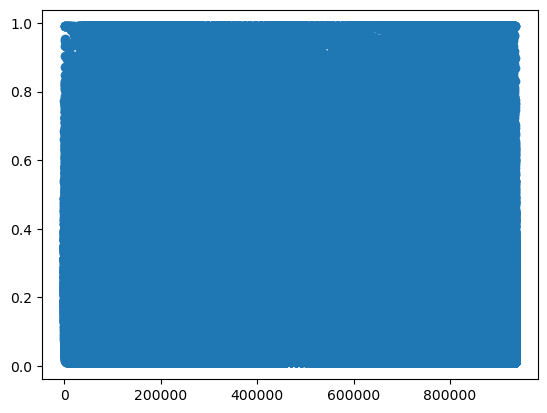

In [20]:
plt.plot(volume_0_pred_train.detach().numpy(), 'o')

In [21]:
def add_bg(mask_long, params):
    resume_params = np.copy(mask_long)
    no_bg_indices = np.where(mask_long == 1)[0]
    for i, index in enumerate(no_bg_indices):
        resume_params[index] = params[i]
    return resume_params

def back_to_3D(mask_long, parames_1d, shape):
    params_with_bg = add_bg(mask_long, parames_1d.detach().numpy())
    params_3d = np.reshape(params_with_bg, shape)
    return params_3d

In [28]:
lambda_par_pred_train_3d = back_to_3D(mask_100206_long_pro, lambda_par_pred_train, (145, 174, 145))

In [29]:
lambda_iso_pred_train_3d = back_to_3D(mask_100206_long_pro, lambda_iso_pred_train, (145, 174, 145))

In [30]:
volume_0_pred_train_3d = back_to_3D(mask_100206_long_pro, volume_0_pred_train, (145, 174, 145))

In [31]:
volume_1_pred_train_3d = back_to_3D(mask_100206_long_pro, volume_1_pred_train, (145, 174, 145))

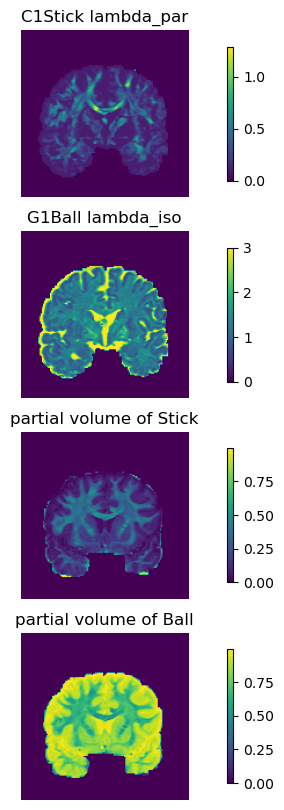

In [32]:
fig, axs = plt.subplots(4, 1, figsize=[10, 10])
axs = axs.ravel()

cf = axs[0].imshow(lambda_par_pred_train_3d[:,100,:].squeeze().T, origin='lower')
axs[0].set_title("C1Stick lambda_par")
axs[0].set_axis_off()
fig.colorbar(cf, ax=axs[0], shrink=0.8)

cf = axs[1].imshow(lambda_iso_pred_train_3d[:,100,:].squeeze().T, origin='lower')
axs[1].set_title("G1Ball lambda_iso")
axs[1].set_axis_off()
fig.colorbar(cf, ax=axs[1], shrink=0.8)

cf = axs[2].imshow(volume_0_pred_train_3d[:,110,:].squeeze().T, origin='lower')
axs[2].set_title("partial volume of Stick")
axs[2].set_axis_off()
fig.colorbar(cf, ax=axs[2], shrink=0.8)

cf = axs[3].imshow(volume_1_pred_train_3d[:,110,:].squeeze().T, origin='lower')
axs[3].set_title("partial volume of Ball")
axs[3].set_axis_off()
fig.colorbar(cf, ax=axs[3], shrink=0.8)

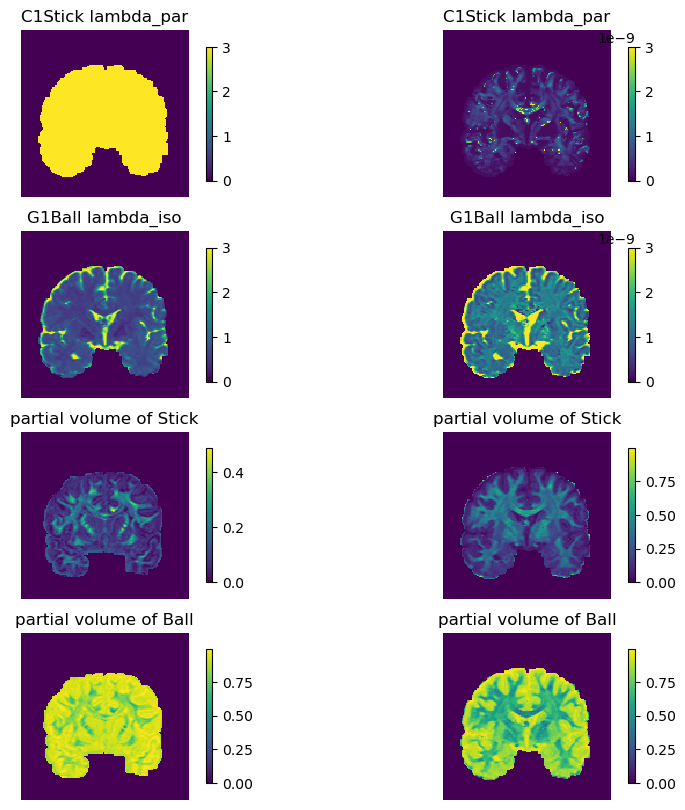

In [53]:
fig, axs = plt.subplots(4, 2, figsize=[10, 10])
axs = axs.ravel()

cf = axs[0].imshow(lambda_par_pred_train_3d[:,100,:].squeeze().T, origin='lower', interpolation='nearest')
axs[0].set_title("C1Stick lambda_par")
axs[0].set_axis_off()
fig.colorbar(cf, ax=axs[0], shrink=0.8)

cf = axs[1].imshow(fitted_parameters.get("C1Stick_1_lambda_par").squeeze().T, origin='lower', interpolation='nearest')
axs[1].set_title("C1Stick lambda_par")
axs[1].set_axis_off()
fig.colorbar(cf, ax=axs[1], shrink=0.8)

cf = axs[2].imshow(lambda_iso_pred_train_3d[:,100,:].squeeze().T, origin='lower', interpolation='nearest')
axs[2].set_title("G1Ball lambda_iso")
axs[2].set_axis_off()
fig.colorbar(cf, ax=axs[2], shrink=0.8)

cf = axs[3].imshow(fitted_parameters.get("G1Ball_1_lambda_iso").squeeze().T, origin='lower', interpolation='nearest')
axs[3].set_title("G1Ball lambda_iso")
axs[3].set_axis_off()
fig.colorbar(cf, ax=axs[3], shrink=0.8)

cf = axs[4].imshow(volume_0_pred_train_3d[:,110,:].squeeze().T, origin='lower', interpolation='nearest')
axs[4].set_title("partial volume of Stick")
axs[4].set_axis_off()
fig.colorbar(cf, ax=axs[4], shrink=0.8)
cf = axs[5].imshow(fitted_parameters.get("partial_volume_0").squeeze().T, origin='lower', interpolation='nearest')
axs[5].set_title("partial volume of Stick")
axs[5].set_axis_off()
fig.colorbar(cf, ax=axs[5], shrink=0.8)

cf = axs[6].imshow(volume_1_pred_train_3d[:,110,:].squeeze().T, origin='lower', interpolation='nearest')
axs[6].set_title("partial volume of Ball")
axs[6].set_axis_off()
fig.colorbar(cf, ax=axs[6], shrink=0.8)
cf = axs[7].imshow(fitted_parameters.get("partial_volume_1").squeeze().T, origin='lower', interpolation='nearest')
axs[7].set_title("partial volume of Ball")
axs[7].set_axis_off()
fig.colorbar(cf, ax=axs[7], shrink=0.8)

In [33]:
scan_100206_slice = scan_100206[:, 100, :, :]

In [34]:
def get_acquisition_scheme(bvals, gradient_directions):
    delta = 0.0106
    Delta = 0.0431
    return acquisition_scheme_from_bvalues(bvals, gradient_directions, delta, Delta)

In [35]:
scheme_hcp_100206_slice = get_acquisition_scheme(bvals_all*1e9, n_all.T)

In [49]:
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
BAS_mod = MultiCompartmentModel(models=[stick, ball])

We highly recommend installing numba for faster function execution and model fitting.
We highly recommend installing pathos to take advantage of multicore processing.


In [50]:
BAS_fit_hcp_100206_slice = BAS_mod.fit(scheme_hcp_100206_slice, scan_100206_slice, mask_100206[:,100,:])

Setup brute2fine optimizer in 0.2092270851135254 seconds
Fitting of 8433 voxels complete in 198.88885593414307 seconds.
Average of 0.023584591003693 seconds per voxel.


In [52]:
fitted_parameters = BAS_fit_hcp_100206_slice.fitted_parameters

In [111]:
fitted_parameters.keys()

dict_keys(['C1Stick_1_mu', 'C1Stick_1_lambda_par', 'G1Ball_1_lambda_iso', 'partial_volume_0', 'partial_volume_1'])